In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers

#### Examples: run one cell

In [2]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [5]:
### Example: high- vs low- entanglement states ###

function classify_state(n, label; threshold=0.6, max_iter=1000)
    state = rand_state(n)
    iter = 0
    if label == 1
        while von_neumann_entropy(state, 1) < threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    else
        while von_neumann_entropy(state, 1) > threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") :
    return state
end

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 10
states1 = [classify_state(n, 1) for i=1:n_samples*2]
states2 = [classify_state(n, -1) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

#### Model parameters

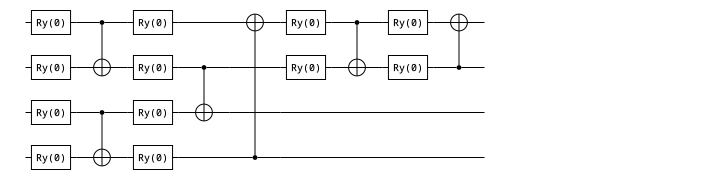

In [6]:
iters = 300 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function

##### QCNN #####
cost = circ_Z
ansatz = circ_Ry_conv # circ_Ry_conv, circ_Ry2_conv, circ_SU4_conv
circ = build_QCNN(n, ansatz=ansatz)
################

##### QNN #####
# cost = circ_Zsum
# ansatz = circ_HEA
# depth = ceil(Int, log2(n))
# circ = build_QNN(n, depth, ansatz=ansatz)
###############

##### Model #####
# model = GeneralModel(n=n, circ=circ, ansatz=ansatz, cost=cost)
model = InvariantModel(n=n, circ=circ, ansatz=ansatz, cost=cost)
#################

initialize_params(model);

YaoPlots.plot(circ)
# YaoPlots.plot(cost(n))

#### Run

In [7]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, model, iters, optim; sig=sig, verbose=false);

Initial: loss = 1.3516295361523325, tr_acc = 0.35, te_acc = 0.225
Final: loss = 0.36762982029478547, tr_acc = 0.85, te_acc = 0.75


#### Plot

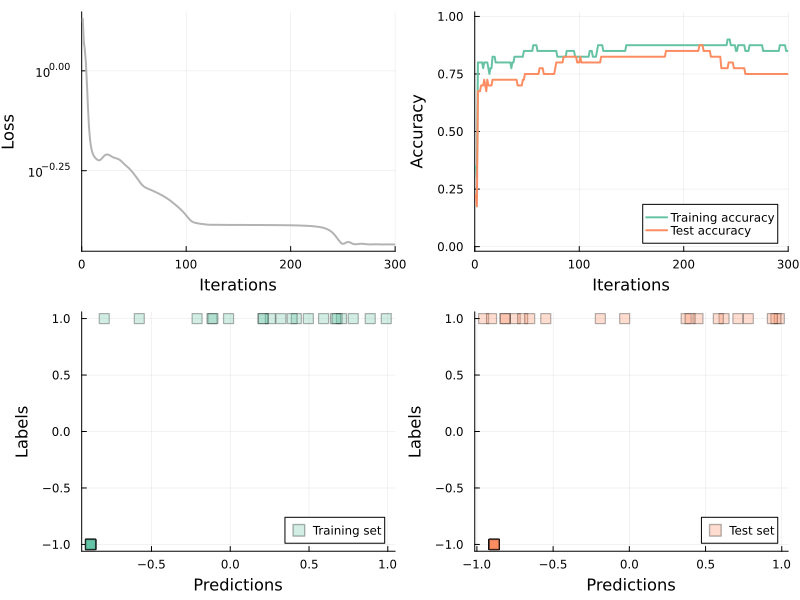

In [8]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [ ]:
# savefig("qcsnn_forr_n4_conv_Ry_overlap.pdf")

"/home/stefano/GitRepos/QComp.jl/notebooks/qcsnn_forr_n4_conv_Ry_overlap.pdf"